<a href="https://colab.research.google.com/github/WojciechTyczynski/Autoencoders-for-image-quality-improvement-with-OMHU/blob/main/brightness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Support funtions

In [ ]:
def imshow(img):
    #img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

# Dataset CIFAR10

In [ ]:
transform = transforms.Compose(
        [transforms.ToTensor()])

# Load dataset normal
batch_size = 20

trainset = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/deep_learning', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/deep_learning', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

used_categories = range(len(classes))

train_data_iter = iter(trainloader)
test_data_iter = iter(testloader)
print('used classes:', classes)

Files already downloaded and verified
Files already downloaded and verified
used classes: ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [ ]:
import random 
transform_noise = transforms.Compose(
        [transforms.ToTensor(), 
         transforms.Lambda(lambda x : x + random.randint(-3,3)/10 * torch.ones_like(x))])

# Load dataset normal
batch_size = 20

trainset_noise = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/deep_learning', train=True,
                                        download=True, transform=transform_noise)
trainloader_noise = torch.utils.data.DataLoader(trainset_noise, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

testset_noise = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/deep_learning', train=False,
                                       download=True, transform=transform_noise)
testloader_noise = torch.utils.data.DataLoader(testset_noise, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

used_categories = range(len(classes))

train_data_iter_noise = iter(trainloader_noise)
test_data_iter_noise = iter(testloader_noise)
print('used classes:', classes)

Files already downloaded and verified
Files already downloaded and verified
used classes: ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


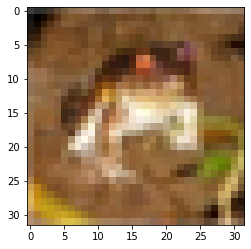

In [ ]:
images_noise, labels = train_data_iter_noise.next()
images, _ = train_data_iter.next()
imshow(images[0])

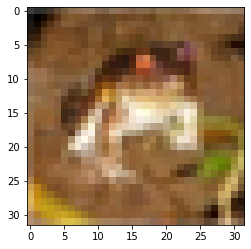

In [ ]:
imshow(images_noise[0])

In [ ]:
print("# Training data")
print("Number of points:", len(trainset))
x, y = next(iter(trainloader))
print("Batch dimension [B x C x H x W]:", x.shape)
print("Number of distinct labels:", len(set(trainset.targets)))


print("\n# Test data")
print("Number of points:", len(testset))
x, y = next(iter(testloader))
print("Batch dimension [B x C x H x W]:", x.shape)
print("Number of distinct labels:", len(set(testset.targets)))

# Training data
Number of points: 50000
Batch dimension [B x C x H x W]: torch.Size([20, 3, 32, 32])
Number of distinct labels: 10

# Test data
Number of points: 10000
Batch dimension [B x C x H x W]: torch.Size([20, 3, 32, 32])
Number of distinct labels: 10


# Network


In [ ]:
class ConvBrightnessAutoencoder(nn.Module):
  def __init__(self):
      super(ConvBrightnessAutoencoder, self).__init__()

      #Encoder
      self.conv1 = nn.Conv2d(3, 24, 3, stride=1, padding=0)
      self.conv2 = nn.Conv2d(24, 48, 3, stride=1, padding=0)
      self.conv3 = nn.Conv2d(48, 96, 3, stride=1, padding=0)

      #Decoder
      self.t_conv1 = nn.ConvTranspose2d(96, 48, 3, stride=1, padding=0)
      self.t_conv2 = nn.ConvTranspose2d(48, 24, 3, stride=1, padding=0)
      self.t_conv3 = nn.ConvTranspose2d(24, 3, 3, stride=1, padding=0)
     

  def forward(self, x):
      x = F.relu(self.conv1(x))
      x = F.relu(self.conv2(x))
      x = F.relu(self.conv3(x))
      x = F.relu(self.t_conv1(x))
      x = F.relu(self.t_conv2(x))
      x = F.sigmoid(self.t_conv3(x))

      return x
  
#Instantiate the model
model = ConvBrightnessAutoencoder()
print(model)

ConvBrightnessAutoencoder(
  (conv1): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(24, 48, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1))
  (t_conv1): ConvTranspose2d(96, 48, kernel_size=(3, 3), stride=(1, 1))
  (t_conv2): ConvTranspose2d(48, 24, kernel_size=(3, 3), stride=(1, 1))
  (t_conv3): ConvTranspose2d(24, 3, kernel_size=(3, 3), stride=(1, 1))
)


In [ ]:
#Loss function
# criterion = nn.BCELoss()
criterion = nn.MSELoss()

#Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

device = get_device()
print(device)
model.to(device)

cuda:0


ConvBrightnessAutoencoder(
  (conv1): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(24, 48, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1))
  (t_conv1): ConvTranspose2d(96, 48, kernel_size=(3, 3), stride=(1, 1))
  (t_conv2): ConvTranspose2d(48, 24, kernel_size=(3, 3), stride=(1, 1))
  (t_conv3): ConvTranspose2d(24, 3, kernel_size=(3, 3), stride=(1, 1))
)

In [ ]:
def save_image(image, name):
  plt.imshow(np.transpose(image, (1, 2, 0)))  # convert from Tensor image
  plt.savefig('/content/drive/MyDrive/deep_learning/{}03noise.jpg'.format(name))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 	Training Loss: 0.325123.  Test Loss: 0.242835
Epoch: 2 	Training Loss: 0.226035.  Test Loss: 0.200717
Epoch: 3 	Training Loss: 0.206783.  Test Loss: 0.199321
Epoch: 4 	Training Loss: 0.195887.  Test Loss: 0.195100
Epoch: 5 	Training Loss: 0.188112.  Test Loss: 0.180497
Epoch: 6 	Training Loss: 0.182765.  Test Loss: 0.196576
Epoch: 7 	Training Loss: 0.178674.  Test Loss: 0.177053
Epoch: 8 	Training Loss: 0.175323.  Test Loss: 0.166770
Epoch: 9 	Training Loss: 0.171490.  Test Loss: 0.165307
Epoch: 10 	Training Loss: 0.169112.  Test Loss: 0.167049
Epoch: 11 	Training Loss: 0.168502.  Test Loss: 0.165614
Epoch: 12 	Training Loss: 0.165897.  Test Loss: 0.164549
Epoch: 13 	Training Loss: 0.164052.  Test Loss: 0.163607
Epoch: 14 	Training Loss: 0.164328.  Test Loss: 0.161640
Epoch: 15 	Training Loss: 0.161663.  Test Loss: 0.155678
Epoch: 16 	Training Loss: 0.160731.  Test Loss: 0.154537
Epoch: 17 	Training Loss: 0.159054.  Test Loss: 0.153045
Epoch: 18 	Training Loss: 0.158354.  Tes

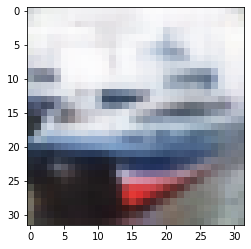

In [ ]:
#Epochs
n_epochs = 50
epoch_train_loss = []
epoch_test_loss = []
epoch_train_improvement = []
epoch_test_improvement = []



for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    test_loss = 0.0
    train_improvement = 0
    test_improvement = 0
    added_noise_train = 0
    added_noise_test = 0

    #Training
    for (data, data_noise) in zip(trainloader, trainloader_noise):
        images, _ = data
        noisy_imgs, _ = data_noise
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        noisy_imgs=noisy_imgs.to(device)
        images = images.to(device)

        optimizer.zero_grad()
        outputs = model(noisy_imgs)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()*images.size(0)
        train_improvement += criterion(outputs,noisy_imgs).item()*images.size(0)
        added_noise_train += criterion(images,noisy_imgs).item()*images.size(0)
  
    epoch_train_loss.append(train_loss/len(trainloader))

    with torch.no_grad():

        for (data,data_noisey,turn) in zip(testloader, testloader_noise, range(len(testloader))):

            test_images, _ = data
            noisy_test_images, _ = data_noisey
            noisy_test_images = np.clip(noisy_test_images, 0., 1.)
            noisy_test_images=noisy_test_images.to(device)
            test_images = test_images.to(device)

            output_test = model(noisy_test_images)
            if turn==0:
              # save the image before model, on purpose always with the same name so we have it to compare
              save_image(test_images[1].cpu(), 'base')
              save_image(noisy_test_images[1].cpu(), 'noisy')
              # save the image run through the model
              save_image(output_test[1].cpu(), epoch)

            # gather data for the validation step
            test_loss += (criterion(output_test, test_images).item()*test_images.size(0))
            test_improvement += criterion(output_test,noisy_test_images).item()*test_images.size(0)
            added_noise_test += criterion(test_images,noisy_test_images).item()*test_images.size(0)
        

    train_loss = train_loss/len(trainloader)
    test_loss = test_loss/len(testloader)

    epoch_test_loss.append(test_loss)

    percentage_improvement_train = ((added_noise_train-train_improvement)/added_noise_train)*100
    percentage_improvement_test = ((added_noise_test-test_improvement)/added_noise_test)*100

    epoch_test_improvement.append(percentage_improvement_test)
    epoch_train_improvement.append(percentage_improvement_train)


    print('Epoch: {} \tTraining Loss: {:.6f}.  Test Loss: {:.6f}'.format(epoch, train_loss, test_loss))

import pandas as pd
errors = {'train' : epoch_train_loss, 'test' : epoch_test_loss}
df_errors = pd.DataFrame(data = errors)
df_errors.to_csv('/content/drive/MyDrive/deep_learning/noise_errors.csv')

torch.save(model.state_dict(), '/content/drive/MyDrive/deep_learning/bright_n_dark.pth')

In [ ]:
# obtain one batch of training images
dataiter = iter(testloader)
images, labels = dataiter.next()
images, labels = dataiter.next()
# convert images to numpy for display
imshow(images[16])

In [ ]:
dataiter_noise = iter(testloader_noise)
images_noise, _ = dataiter_noise.next()
images_noise, _ = dataiter_noise.next()
images_noise = np.clip(images_noise, 0., 1.)
imshow(images_noise[16])

In [ ]:
images_noise=images_noise.to(device)
images_noise = images_noise.to(device)

output = model(images_noise)
imshow(output[16].detach().cpu())

In [ ]:
def show_image(batch, imagenumber, factor):

  dataiter = iter(testloader)
  dataiter_noise = iter(testloader_noise)

  for times in range(batch):
    images, labels = dataiter.next()
    images_noise, _ = dataiter_noise.next()

  images_noise = np.clip((images + factor * torch.ones(*images.shape)), 0., 1.)

  # OUTPUT
  images_noise=images_noise.to(device)
  images_noise = images_noise.to(device)
  output = model(images_noise)

  # create figure
  fig = plt.figure(figsize=(20, 14))

  # setting values to rows and column variables
  rows = 3
  columns = 1

  # reading images
  Image1 = images[imagenumber]
  Image2 = (images + factor * torch.ones(*images.shape))[imagenumber]
  Image3 = output[imagenumber].detach().cpu()

  # Adds a subplot at the 1st position
  fig.add_subplot(rows, columns, 1)

  # showing image
  plt.imshow(np.transpose(Image1, (1, 2, 0)))
  plt.axis('off')
  plt.title("Normal")

  # Adds a subplot at the 2nd position
  fig.add_subplot(rows, columns, 2)

  # showing image
  plt.imshow(np.transpose(Image2, (1, 2, 0)))
  plt.axis('off')
  plt.title("Bright/Dark")

  # Adds a subplot at the 3rd position
  fig.add_subplot(rows, columns, 3)

  # showing image
  plt.imshow(np.transpose(Image3, (1, 2, 0)))
  plt.axis('off')
  plt.title("Model Output")

def show_image_save(batch, imagenumber, factor):

  dataiter = iter(testloader)
  dataiter_noise = iter(testloader_noise)

  for times in range(batch):
    images, labels = dataiter.next()
    images_noise, _ = dataiter_noise.next()

  images_noise = np.clip((images + factor * torch.ones(*images.shape)), 0., 1.)

  # OUTPUT
  images_noise=images_noise.to(device)
  images_noise = images_noise.to(device)
  output = model(images_noise)

  # create figure
  fig = plt.figure(figsize=(20, 14))

  # setting values to rows and column variables
  rows = 3
  columns = 1

  # reading images
  Image1 = images[imagenumber]
  Image2 = (images + factor * torch.ones(*images.shape))[imagenumber]
  Image3 = output[imagenumber].detach().cpu()

  # Adds a subplot at the 1st position
  fig.add_subplot(rows, columns, 1)

  # showing image
  plt.imshow(np.transpose(Image1, (1, 2, 0)))
  plt.axis('off')
  plt.title("Normal")

  # Adds a subplot at the 2nd position
  fig.add_subplot(rows, columns, 2)

  # showing image
  plt.imshow(np.transpose(Image2, (1, 2, 0)))
  plt.axis('off')
  plt.title("Bright/Dark")

  # Adds a subplot at the 3rd position
  fig.add_subplot(rows, columns, 3)

  # showing image
  plt.imshow(np.transpose(Image3, (1, 2, 0)))
  plt.axis('off')
  plt.title("Model Output")

  plt.savefig('image_saved{}{}'.format(batch,imagenumber),figsize=(90,20))



/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


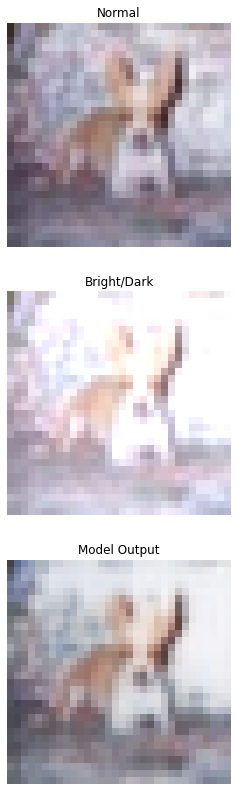

In [ ]:
show_image(25, 8, +0.3)

In [ ]:
# FOR NOISE

def show_image(batch, imagenumber, factor):

  dataiter = iter(testloader)
  dataiter_noise = iter(testloader_noise)

  for times in range(batch):
    images, labels = dataiter.next()
    images_noise, _ = dataiter_noise.next()
  
  transformed_image = images + factor * torch.randn(*images.shape)
  
  images_noise = np.clip(transformed_image, 0., 1.)

  # OUTPUT
  images_noise=images_noise.to(device)
  images_noise = images_noise.to(device)
  output = model(images_noise)

  # create figure
  fig = plt.figure(figsize=(20, 14))

  # setting values to rows and column variables
  rows = 3
  columns = 1

  # reading images
  Image1 = images[imagenumber]
  Image2 = transformed_image[imagenumber]
  Image3 = output[imagenumber].detach().cpu()

  # Adds a subplot at the 1st position
  fig.add_subplot(rows, columns, 1)

  # showing image
  plt.imshow(np.transpose(Image1, (1, 2, 0)))
  plt.axis('off')
  plt.title("Normal")

  # Adds a subplot at the 2nd position
  fig.add_subplot(rows, columns, 2)

  # showing image
  plt.imshow(np.transpose(Image2, (1, 2, 0)))
  plt.axis('off')
  plt.title("Noisy")

  # Adds a subplot at the 3rd position
  fig.add_subplot(rows, columns, 3)

  # showing image
  plt.imshow(np.transpose(Image3, (1, 2, 0)))
  plt.axis('off')
  plt.title("Model Output")

In [ ]:
# FOR NOISE AND BRIGHTNESS
def show_image(batch, imagenumber, factor_noise, factor_brightness):

  dataiter = iter(testloader)
  dataiter_noise = iter(testloader_noise)

  for times in range(batch):
    images, labels = dataiter.next()
    images_noise, _ = dataiter_noise.next()

  transformed_images = images + factor_noise * torch.randn(*images.shape) + factor_brightness * torch.ones(*images.shape)
  images_noise = np.clip(transformed_images, 0., 1.)

  # OUTPUT
  images_noise=images_noise.to(device)
  images_noise = images_noise.to(device)
  output = model(images_noise)

  # create figure
  fig = plt.figure(figsize=(20, 14))

  # setting values to rows and column variables
  rows = 3
  columns = 1

  # reading images
  Image1 = images[imagenumber]
  Image2 = (transformed_images)[imagenumber]
  Image3 = output[imagenumber].detach().cpu()

  # Adds a subplot at the 1st position
  fig.add_subplot(rows, columns, 1)

  # showing image
  plt.imshow(np.transpose(Image1, (1, 2, 0)))
  plt.axis('off')
  plt.title("Normal")

  # Adds a subplot at the 2nd position
  fig.add_subplot(rows, columns, 2)

  # showing image
  plt.imshow(np.transpose(Image2, (1, 2, 0)))
  plt.axis('off')
  plt.title("Noisy")

  # Adds a subplot at the 3rd position
  fig.add_subplot(rows, columns, 3)

  # showing image
  plt.imshow(np.transpose(Image3, (1, 2, 0)))
  plt.axis('off')
  plt.title("Model Output")